In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from collections import deque

In [ ]:
words=open('/content/drive/MyDrive/Anshul/names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
chars=sorted(list((set(''.join(words)))))
stoi={ch:i+1 for i, ch in enumerate(chars)}
stoi['.']=0
itos={i:ch for ch, i in stoi.items()}
vocab_size=len(itos)

In [ ]:
block_size=3

def build_dataset(words):

  X=[]
  Y=[]
  context=deque()
  for w in words:
    context.extend([0]*block_size)
    X.append(list(context))
    Y.append(stoi[w[0][0]])
    for i in range(len(w)):
      context.append(stoi[w[i]])
      context.popleft()
      X.append(list(context))
      if i==len(w)-1:
        Y.append(0)
        break
      Y.append(stoi[w[i+1]])
    context=deque()
    # print(context)
  # print(X)
  # print(Y)
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte= build_dataset(words[n2:])



In [ ]:
print(Xdev.shape, Ydev.shape)

torch.Size([22655, 3]) torch.Size([22655])


In [ ]:
print(n2,n1,n2-n1)

28829 25626 3203


In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight=torch.randn((fan_in, fan_out), generator=g)/ fan_in**0.5
    self.bias=torch.randn(fan_out) if bias else None

  def __call__(self, x):
    self.out= x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])

class BacthNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps=eps
    self.momentum=momentum
    self.training=True
    #parameters
    self.gamma=torch.ones(dim)
    self.beta=torch.zeros(dim)

    #buffers
    self.running_mean=torch.zeros(dim)
    self.running_var=torch.ones(dim)

  def __call__(self,x):
    if self.training:
      xmean=x.mean(0, keepdim=True)   #batch mean
      xvar=x.var(0,keepdim=True)      #batch variance

    else:
      xmean=self.running_mean
      xvar=self.running_var

    xhat=(x-xmean)/torch.sqrt(xvar+self.eps)  #normalize to unit variance
    self.out=self.gamma*xhat+self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
        self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out=torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd=10
n_hidden=200
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),generator=g)
layers=[
    Linear(n_embd*block_size, n_hidden), BacthNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BacthNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BacthNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BacthNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BacthNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BacthNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma*=0.1   #making last layer less confident

  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight*=5/3

parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))    #number of parameters in total

for p in parameters:
  p.requires_grad=True

174751


In [ ]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):

  #minibatch
  ix=torch.randint(0, Xtr.shape[0],(32,))
  Xb, Yb=Xtr[ix], Ytr[ix]

  #forward pass
  emb=C[Xb]       #embed the characters into vectors
  x=emb.view(emb.shape[0],-1)
  for layer in layers:
    x=layer(x)
  loss=F.cross_entropy(x, Yb)

  #backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad=None
  loss.backward()

  #update
  lr=0.1 if i<100000 else 0.01
  for p in parameters:
    p.data+=-lr*p.grad

  #track status

  if i%10000==0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
print(loss.item())

      0/ 200000: 3.2769
  10000/ 200000: 2.1494
  20000/ 200000: 1.8311
  30000/ 200000: 2.3482
  40000/ 200000: 2.2050
  50000/ 200000: 2.1126
  60000/ 200000: 2.1662
  70000/ 200000: 1.9306
  80000/ 200000: 2.3356
  90000/ 200000: 2.0162
 100000/ 200000: 2.1055
 110000/ 200000: 1.8967
 120000/ 200000: 1.8603
 130000/ 200000: 2.0394
 140000/ 200000: 1.8787
 150000/ 200000: 2.5975
 160000/ 200000: 2.0277
 170000/ 200000: 2.3450
 180000/ 200000: 2.5894
 190000/ 200000: 1.9102
1.6303654909133911


layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 11.75%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 14.11%
layer 8 (      Tanh): mean +0.01, std 0.74, saturated: 14.38%
layer 11 (      Tanh): mean +0.01, std 0.74, saturated: 14.09%
layer 14 (      Tanh): mean +0.01, std 0.75, saturated: 15.28%


Text(0.5, 1.0, 'activation distribution')

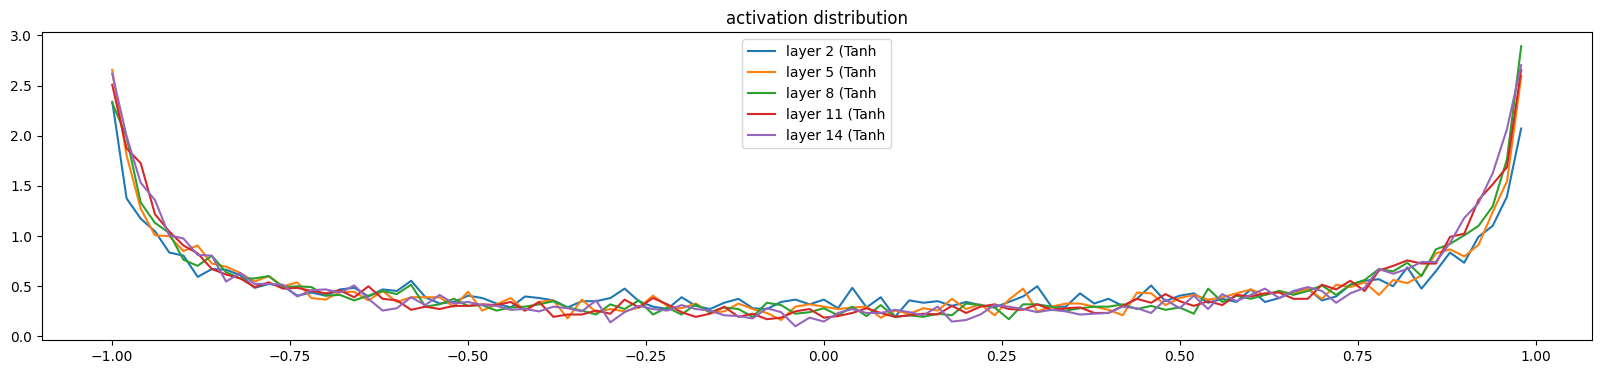

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.225499e-03
layer 5 (      Tanh): mean +0.000000, std 2.365593e-03
layer 8 (      Tanh): mean +0.000000, std 2.476498e-03
layer 11 (      Tanh): mean +0.000000, std 2.298912e-03
layer 14 (      Tanh): mean +0.000000, std 2.142865e-03


Text(0.5, 1.0, 'gradient distribution')

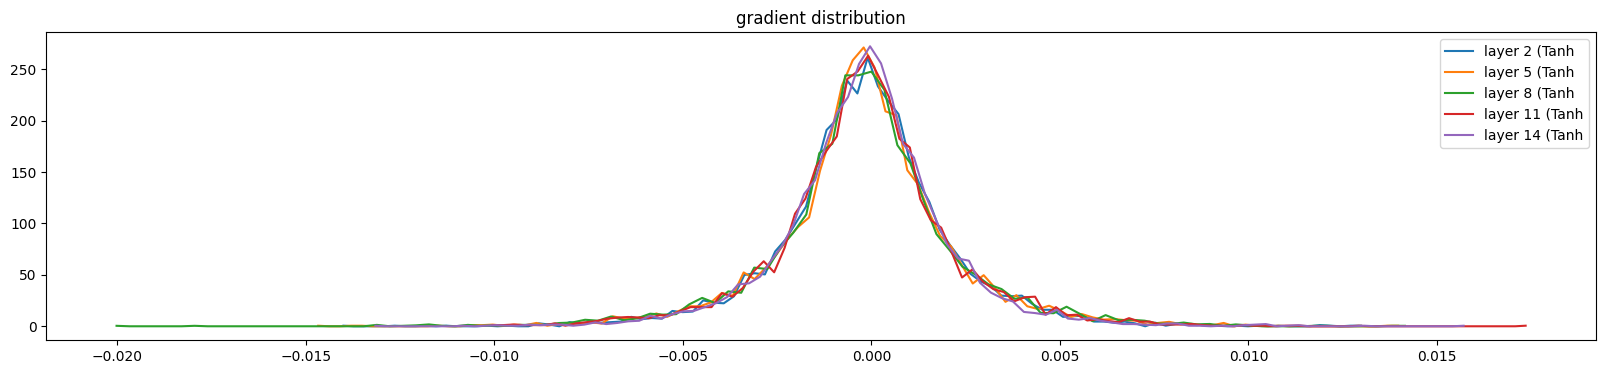

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.506511e-02 | grad:data ratio 1.391203e-02
weight  (30, 200) | mean +0.000050 | std 5.804359e-03 | grad:data ratio 1.645108e-02
weight (200, 200) | mean +0.000022 | std 3.491981e-03 | grad:data ratio 2.230320e-02
weight (200, 200) | mean -0.000020 | std 3.812067e-03 | grad:data ratio 2.447661e-02
weight (200, 200) | mean -0.000014 | std 3.662194e-03 | grad:data ratio 2.387619e-02
weight (200, 200) | mean -0.000015 | std 3.161547e-03 | grad:data ratio 2.155122e-02
weight  (200, 27) | mean -0.000105 | std 6.670802e-03 | grad:data ratio 2.673964e-02


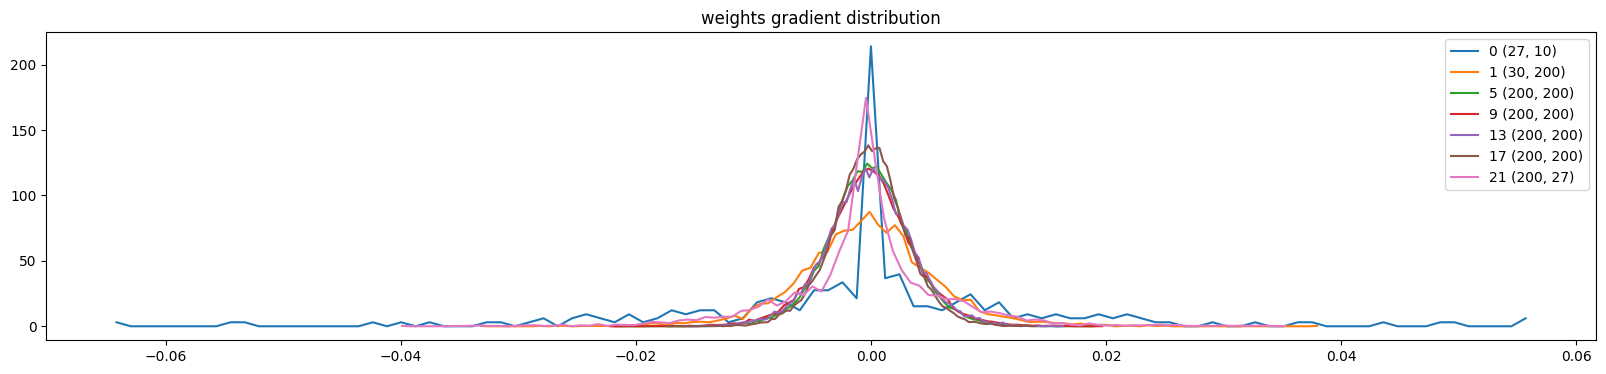

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

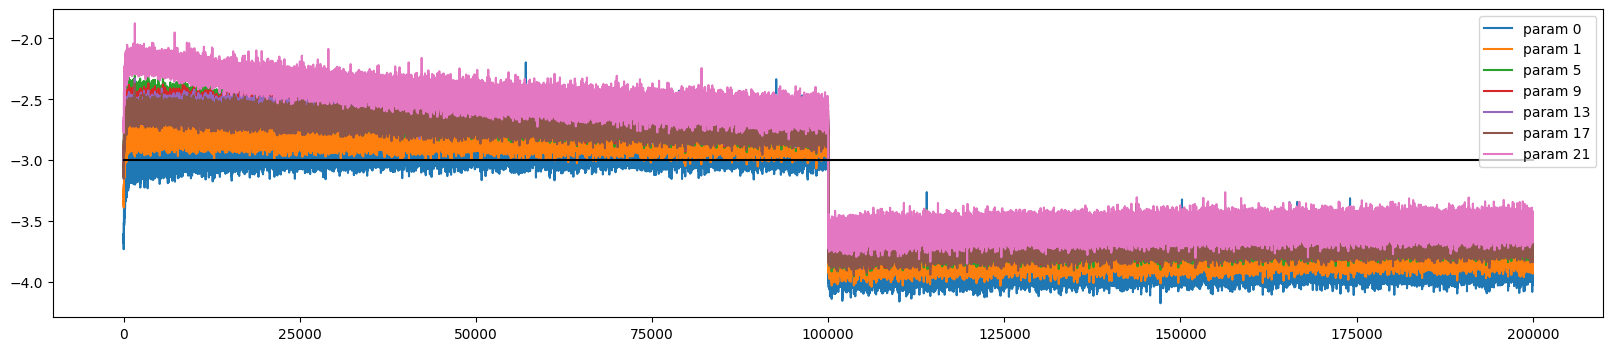

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9712969064712524
val 2.0715084075927734


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
med.
rylla.
emmadiendra.
grace.
kaitli.
jemilopi.
eden.
edrixandelyn.
malaia.
noshubergian.
jest.
jair.
jenionnie.
casuka.
geder.
yarue.
eli.
kayshayveoluwhit.
